## Uplift-моделирование

In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, auc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Пример данных
data = pd.DataFrame({
    'user_id': [1, 2, 3, 4, 5, 6],
    'treatment': [1, 0, 1, 0, 1, 0],
    'num_trips': [10, 8, 12, 7, 9, 6],
    'avg_trip_cost': [15, 12, 14, 11, 13, 10],
    'gender': ['M', 'F', 'M', 'F', 'M', 'F'],
    'location': ['City A', 'City B', 'City A', 'City B', 'City A', 'City B'],
    'target': [5, 2, 7, 1, 4, 0]
})

# Трансформация целевой переменной
data['target_transformed'] = data.apply(
    lambda row: row['target'] if row['treatment'] == 1 else -row['target'], axis=1)

In [3]:
# Целевая переменная и признаки
y = data['target_transformed']
X = data.drop(['target', 'target_transformed', 'user_id'], axis=1)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Предобработка данных
numeric_features = ['num_trips', 'avg_trip_cost']
categorical_features = ['gender', 'location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [4]:
# Модель
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Обучение модели
model.fit(X_train, y_train)

# Оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Predictions:", y_pred)

Mean Squared Error: 1.6202
Predictions: [ 4.98 -0.2 ]


In [5]:
# Применение модели ко всем данным
all_data_predictions = model.predict(X)

# Устанавливаем пороговое значение для предоставления скидок
threshold = 1.0  

# Определение пользователей, которым рекомендуется предоставить скидку
data['predicted_uplift'] = all_data_predictions
data['give_discount'] = data['predicted_uplift'] > threshold

# Вывод пользователей, которым рекомендуется предоставить скидку
users_to_give_discount = data[data['give_discount']]

print("Users to give discount:")
print(users_to_give_discount[['user_id', 'predicted_uplift']])

Users to give discount:
   user_id  predicted_uplift
0        1              4.98
2        3              5.64
4        5              4.24


## Qini-кривая и оценка качества

In [7]:
# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,
    'outcome': outcome,
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


In [8]:
# сортировка данных по uplift_prediction
df = df.sort_values(by='uplift_prediction', ascending=False).reset_index(drop=True)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


In [9]:
# Инициализация переменных для расчёта CGain и Random
nt = 0
nt_1 = 0
nc = 0
nc_1 = 0
cgain = []
random = []
optimum = []
incremental_purchases = 0
opt_incremental_purchases = df['outcome'].sum()

In [10]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0))

In [12]:
# расчет метрики
# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}')

Qini Score: -264.3900000000001


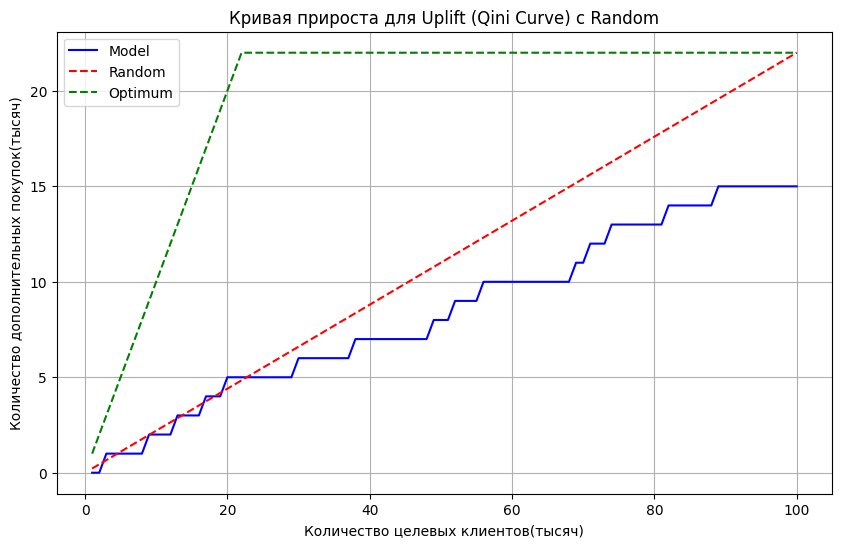

In [16]:
# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Количество целевых клиентов(тысяч)')
plt.ylabel('Количество дополнительных покупок(тысяч)')
plt.title('Кривая прироста для Uplift (Qini Curve) с Random')
plt.legend()
plt.grid(True)
plt.show()

Qini Score: -264.39 указывает на то, что производительность модели значительно хуже, чем случайный отбор. В контексте uplift-моделирования отрицательный Qini Score говорит о том, что предсказания модели неэффективно определяют пользователей, которые бы получили наибольший прирост от воздействия. Такие предсказания даже могут вызывать отрицательный uplift, чего бы не произошло, если бы модель не использовалась вовсе. Это говорит о том, что необходимо улучшить точность модели в предсказании uplift.

## Задание

In [19]:
%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("discountuplift.csv", sep="\t")
discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


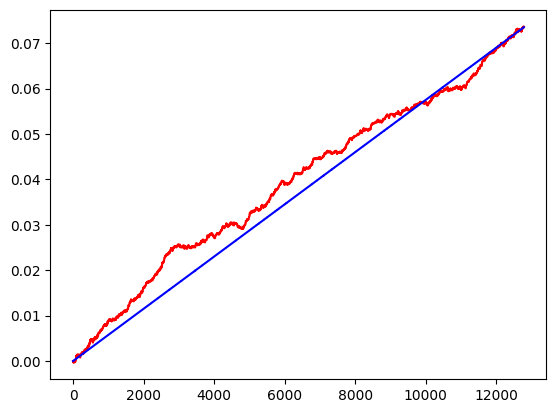

33.17995

In [20]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount)

## Пример проведения A/B-теста для uplift-моделирования

In [ ]:
# загрузим данные пользователей
data = pd.read_csv(FILENAME)

# добавим колонку с группой (контрольная или экспериментальная)
np.random.seed(42)  # для воспроизводимости результатов
data['group'] = np.random.choice(['control', 'experiment'], size=len(data))

# сохраним контрольную и экспериментальную группы в отдельные переменные
control_group = data[data['group'] == 'control']
experiment_group = data[data['group'] == 'experiment'] 

In [ ]:
# добавим колонку с информацией о скидках
data['discount'] = np.where(data['group'] == 'experiment', True, False)

# проверим результат
print(data.head())

In [ ]:
# создадим DataFrame для хранения результатов теста
results = pd.DataFrame(columns=['user_id', 'group', 'num_rides', 'total_spent'])

# симуляция данных для каждой группы
# для простоты примера мы используем случайные данные
for _, row in data.iterrows():
    num_rides = np.random.poisson(lam=5 if row['discount'] else 3)  # предполагаем, что скидки увеличивают среднее количество поездок
    total_spent = num_rides * (20 if row['discount'] else 25)  # допустим, что средняя стоимость поездки отличается
    
    results = results.append({
        'user_id': row['user_id'],
        'group': row['group'],
        'num_rides': num_rides,
        'total_spent': total_spent
    }, ignore_index=True)

# сохраним результаты
results.to_csv('ab_test_results.csv', index=False)

In [ ]:
#После завершения теста анализируются собранные данные:
#сравниваются результаты контрольной и экспериментальной групп;
#оценивается, насколько значимо увеличилось количество поездок в экспериментальной группе;
#применяются статистические тесты для определения значимости различий.

from scipy import stats
  
# загрузим результаты теста
results = pd.read_csv('ab_test_results.csv')

# группируем данные
grouped_results = results.groupby('group').agg({
    'num_rides': ['mean', 'std', 'count'],
    'total_spent': ['mean', 'std', 'count']
})

print(grouped_results)

# сравниваем средние значения количества поездок
control_rides = results[results['group'] == 'control']['num_rides']
experiment_rides = results[results['group'] == 'experiment']['num_rides']

t_stat, p_value = stats.ttest_ind(control_rides, experiment_rides)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# оцениваем, насколько значимо увеличилось количество поездок в экспериментальной группе
if p_value < 0.05:
    print("Различие в количестве поездок между контрольной и экспериментальной группами статистически значимо.")
else:
    print("Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.")


## S-learner

Для чего применяют S-learner:
- Оценка эффективности маркетинговых кампаний. С его помощью анализируют, как скидки или рекламные рассылки влияют на поведение клиентов.
- Оптимизация медицинских вмешательств. Исследуют, как разные методы лечения влияют на здоровье пациентов.
- Повышение эффективности бизнес-процессов. Определяют, какие изменения в процессе ведут к улучшению результатов.

In [24]:
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


In [72]:
df['old_target'] = df['target_class'] - 1

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

In [73]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.25, random_state=1)

In [74]:
# доля значений 1 в целевой переменной из тренировочного датасета
round(df_test[df_test['old_target'] == 1].shape[0] / df_test.shape[0], 5)

0.41176

In [75]:
from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])

# посчитайте intercept
print(s_learner.intercept_)

[ 0.63455629 -0.33398855  0.07575224 -0.37631997]


In [64]:
#pip install scikit-uplift

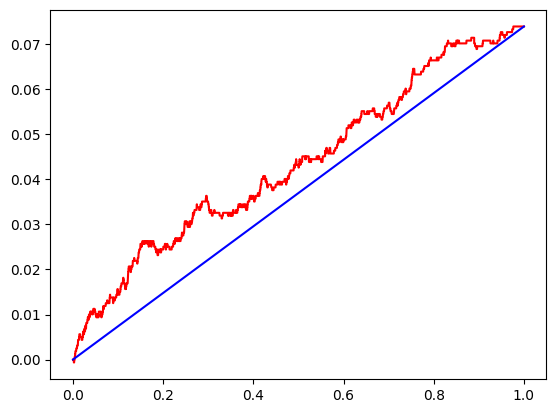

Qini Score: 20.99522


In [13]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# посчитаем uplift на объектах тестовой выборки
uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini = qini_df(df_test)

print("Qini Score:", qini)

## T-learner

— это подход в анализе причинно-следственных связей, который используется для оценки эффекта воздействия на объекты. Да, как и изученный S-learner. Главное различие между ними заключается в следующем: T-learner использует для оценки результата два алгоритма — и неважно, произошло целевое воздействие или нет. 

In [2]:
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(verbose=0, random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])
              
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

In [10]:
t_learner_1 = LogisticRegression(random_state=1)
t_learner_0 = LogisticRegression(random_state=1)
# обучите модели
# t_learner_1 — модель, обученная на выборке с воздействием
df_train_1 = df_train[df_train['used_discount'] == 1]
t_learner_1.fit(X=df_train_1[feature_cols + [treatment_col]], y=df_train_1[target_col])
              
# t_learner_0 — модель, обученная на выборке без воздействия
df_train_0 = df_train[df_train['used_discount'] == 0]
t_learner_0.fit(X=df_train_0[feature_cols + [treatment_col]], y=df_train_0[target_col])

print(t_learner_1.intercept_)
print(t_learner_0.intercept_)

[-0.60797863]
[-0.60090396]


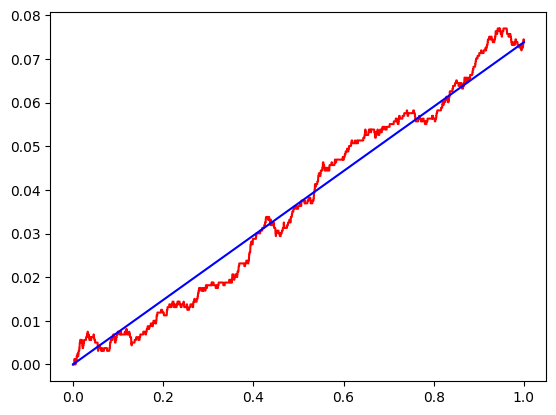

-0.5958

In [12]:
df_test['yes_treatment'] = t_learner_1.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]
df_test['no_treatment'] = t_learner_0.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

round(qini_df(df_test),4)

T-learner хуже сработал, чем S-learner, так как выборка маленькая и есть дисбаланс классов

## Causal ML

In [14]:
!pip install causalml

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 12.8 MB/s eta 0:00:00
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 2.4 MB/s eta 0:00:0000:0100:01
  Using cached Cython-3.0.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.7/937.7 KB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 KB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━

In [5]:
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


In [6]:
np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
discount = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

from sklearn.linear_model import LogisticRegression

#### BaseSClassifier

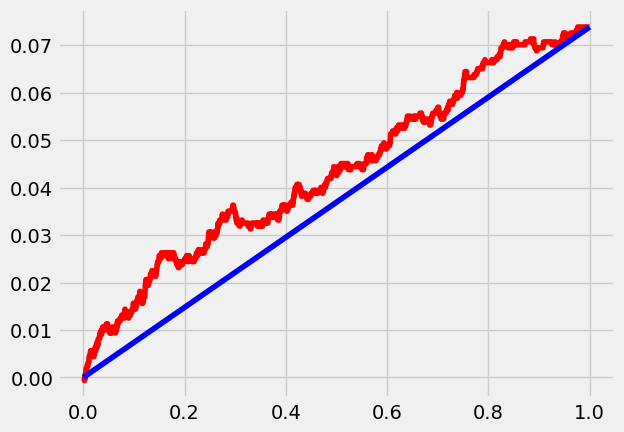

20.99583

In [ ]:
from causalml.inference.meta import BaseSClassifier

s_learner = BaseSClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

round(qini_df(df_test),5)


#### BaseTClassifier

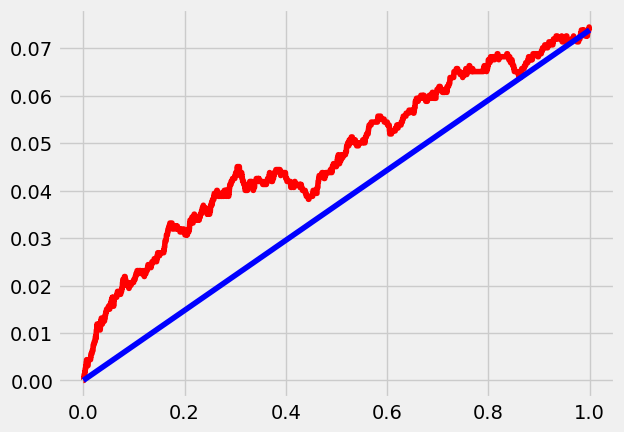

33.32416

In [11]:
from causalml.inference.meta import BaseTClassifier

t_learner = BaseTClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените качество
df_test['uplift_score'] = uplift_vals

round(qini_df(df_test),5)

## X-learner

X-learner борется со смещением выборки. Для этого модель нужно обучить непосредственно на uplift-эффекте. Как это помогает? Эффект известен сразу, а значит выборку для обучения балансировать легче. Выборка с эффектом напрямую попадает в обучающую, из-за этого модели лучше распознают и предсказывают наличие воздействия. 

In [19]:
discount = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()
 
discount['old_target'] = (discount['target_class'] % 2 == 0).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

# разобъём нашу выборку на тестовую и валидационную

df_train, df_test = train_test_split(discount, stratify=discount[[treatment_col, target_col]], random_state=1, test_size=0.25)
df_train.head() 

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


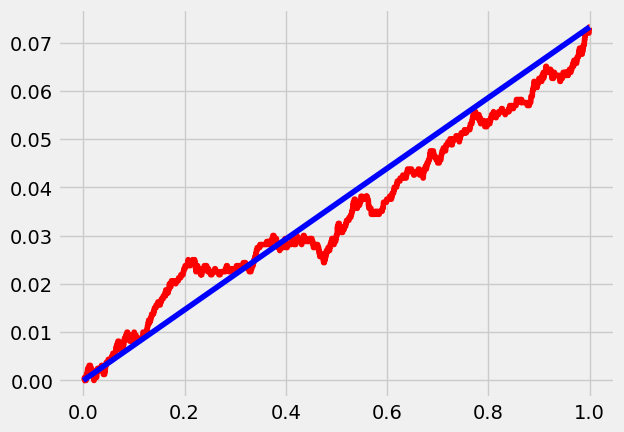

-5.498709999999999

In [15]:
from causalml.inference.meta import BaseXClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# создадим базовый X-learner
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=13), effect_learner=LinearRegression())

# для обучения нужны датафрейм с факторами и колонка с фактом воздействия
x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените Qini Score для обученного классификатора на тестовой выборке
df_test['uplift_score'] = uplift_vals

qini_df(df_test)

## R-learner

Названия методов сформированы прямолинейно:
- S-learner — Single, используется единственный предикатор;
- T-learner — Two, обучаются две модели;
- X-learner — наше допущение верное, потоки данных как бы перекрещиваются;
- R-learner — название происходит от функции потерь, R-loss (об этом далее), которая, в свою очередь, названа в честь Джеймса Робинса

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

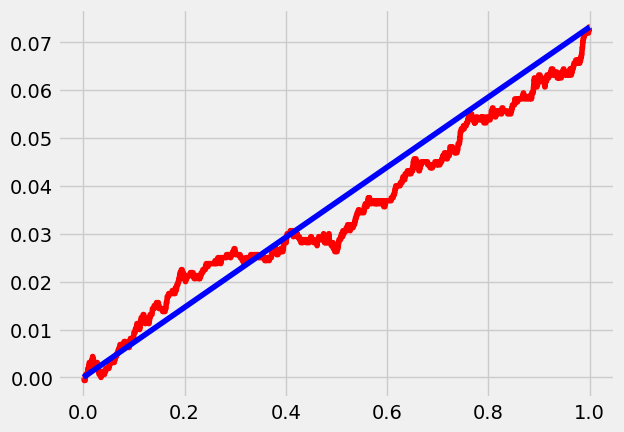

-6.512159999999999

In [18]:
from causalml.inference.meta import BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# создадим базовый R-learner
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(random_state=1), effect_learner=LinearRegression())

# для обучения нужны датафрем с факторами и колонка с фактом воздействия
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените Qini Score для обученного классификатора
df_test['uplift_score'] = uplift_vals

qini_df(df_test)

Качество новой модели опять ухудшилось! Вот так сюрприз! Причина та же самая — размер выборки. К сожалению, X-learner и R-learner дают ощутимый рост качества только на задачах с большим объёмом данных.

## Uplift-деревья

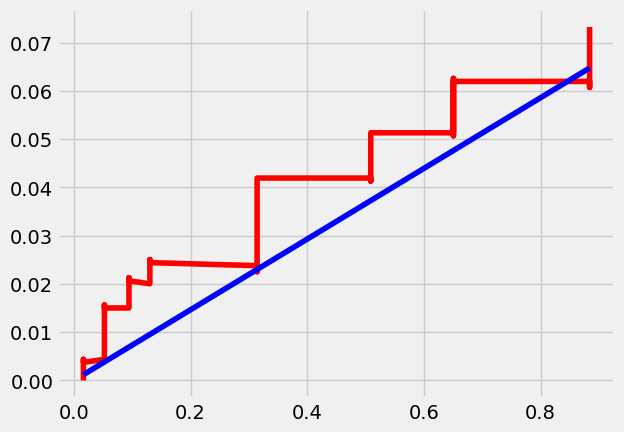

22.393710000000002

In [21]:
from causalml.inference.tree import UpliftTreeClassifier

# создадим базовое uplift-дерево
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)
                
# предскажите uplift-эффект
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))[:,1]

# посчитаем метрики
df_test['uplift_score'] = uplift_vals

qini_df(df_test)

## Применение моделей в продакшен-среде

In [23]:
# загружаем необходимые библиотеки
import warnings

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

df["old_target"] = (df["target_class"] % 2).apply(int)

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

# разобъём нашу выборку на тестовую и валидационную
df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)


In [24]:
from causalml.inference.tree import UpliftTreeClassifier

# создадим uplift-дерево
uplift_model = UpliftTreeClassifier(
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="ED",
    control_name="0",
)

uplift_model.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values,
)

In [25]:
# загружаем необходимые библиотеки
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(uplift_model, f)